In [1]:
!nvidia-smi

Mon Mar 10 10:46:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.24                 Driver Version: 566.24         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 Laptop GPU  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   58C    P0             12W /   35W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# install the torch version that is compatiable according to the cuda version

In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset,Dataset
import torch
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
import pickle
import torch
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report
print("Torch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))



c:\Users\thanredd\Desktop\Personal\DeccanAI\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch Version: 2.6.0+cu126
CUDA Available: True
GPU: NVIDIA RTX A2000 Laptop GPU


In [3]:


# Load the CoNLL-2003 Dataset
dataset = load_dataset("conll2003")

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [4]:
dataset.shape

{'train': (14041, 5), 'validation': (3250, 5), 'test': (3453, 5)}

In [5]:

dataset['train'][0]


{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [6]:
dataset['test'][0]

{'id': '0',
 'tokens': ['SOCCER',
  '-',
  'JAPAN',
  'GET',
  'LUCKY',
  'WIN',
  ',',
  'CHINA',
  'IN',
  'SURPRISE',
  'DEFEAT',
  '.'],
 'pos_tags': [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7],
 'chunk_tags': [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0],
 'ner_tags': [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]}

In [7]:
train_df_raw = pd.DataFrame(dataset['train'])
test_df_raw = pd.DataFrame(dataset['test'])
valid_df_raw = pd.DataFrame(dataset['validation'])

valid_df_raw


,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, T...","[22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7]","[11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0]","[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,"[LONDON, 1996-08-30]","[22, 11]","[11, 12]","[5, 0]"
2,2,"[West, Indian, all-rounder, Phil, Simmons, too...","[22, 22, 21, 22, 22, 38, 11, 15, 11, 15, 22, 1...","[11, 12, 12, 12, 12, 21, 11, 13, 11, 13, 11, 1...","[7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ..."
3,3,"[Their, stay, on, top, ,, though, ,, may, be, ...","[29, 21, 15, 21, 6, 30, 6, 20, 37, 16, 15, 21,...","[11, 12, 13, 11, 0, 3, 0, 21, 22, 1, 13, 11, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ..."
4,4,"[After, bowling, Somerset, out, for, 83, on, t...","[15, 39, 22, 33, 15, 11, 15, 12, 21, 21, 15, 2...","[13, 11, 12, 15, 13, 11, 13, 11, 12, 12, 13, 1...","[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ..."
...,...,...,...,...,...
3245,3245,"[But, the, prices, may, move, in, a, close, ra...","[10, 12, 24, 20, 37, 15, 12, 16, 21, 39, 12, 4...","[0, 11, 12, 21, 22, 13, 11, 12, 12, 13, 11, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3246,3246,"[Brokers, said, blue, chips, like, IDLC, ,, Ba...","[24, 38, 16, 24, 15, 22, 6, 22, 22, 6, 22, 22,...","[11, 21, 11, 12, 13, 11, 0, 11, 12, 0, 11, 12,...","[0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ..."
3247,3247,"[They, said, there, was, still, demand, for, b...","[28, 38, 13, 38, 30, 37, 15, 16, 24, 15, 21, 2...","[11, 21, 11, 21, 22, 22, 13, 11, 12, 13, 11, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3248,3248,"[The, DSE, all, share, price, index, closed, 2...","[12, 21, 12, 21, 21, 21, 38, 11, 24, 10, 11, 2...","[11, 12, 11, 12, 12, 12, 21, 11, 12, 0, 11, 12...","[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
tag_list = dataset['train'].features['ner_tags'].feature.names

tag_map = {label: i for i, label in enumerate(tag_list)}

id2tag = {i: label for i, label in enumerate(tag_list)}

print("Tag List:")
print(tag_list)

print("\nLabel Map (Tag → ID):")
print(tag_map)

print("\nInverse Map (ID → Tag):")
print(id2tag)


Tag List:
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

Label Map (Tag → ID):
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

Inverse Map (ID → Tag):
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


In [9]:
# Function to convert any Hugging Face dataset split to a clean DataFrame
def map_ner_tags(df):
    """
    Convert a Hugging Face dataset split to a DataFrame.
    Maps NER tags from integers to human-readable labels.
    Drops unnecessary columns like pos_tags, chunk_tags, id.
    """
    def map_tags(ner_tags):
        return [tag_list[tag] for tag in ner_tags]

    df['ner_labels'] = df['ner_tags'].apply(map_tags)
    
    # Drop unnecessary columns
    df = df[['tokens', 'ner_labels', 'ner_tags']]
    
    return df



In [10]:
train_df = map_ner_tags(train_df_raw)
test_df = map_ner_tags(test_df_raw)
valid_df = map_ner_tags(valid_df_raw)

In [11]:
print("\nDataset sizes:")
print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(valid_df)} samples")
print(f"Test set: {len(test_df)} samples")


Dataset sizes:
Train set: 14041 samples
Validation set: 3250 samples
Test set: 3453 samples


In [12]:
train_df.head()

,tokens,ner_labels,ner_tags
0,"[EU, rejects, German, call, to, boycott, Briti...","[B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,"[Peter, Blackburn]","[B-PER, I-PER]","[1, 2]"
2,"[BRUSSELS, 1996-08-22]","[B-LOC, O]","[5, 0]"
3,"[The, European, Commission, said, on, Thursday...","[O, B-ORG, I-ORG, O, O, O, O, O, O, B-MISC, O,...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,"[Germany, 's, representative, to, the, Europea...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


In [13]:
test_df.head()

,tokens,ner_labels,ner_tags
0,"[SOCCER, -, JAPAN, GET, LUCKY, WIN, ,, CHINA, ...","[O, O, B-LOC, O, O, O, O, B-PER, O, O, O, O]","[0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,"[Nadim, Ladki]","[B-PER, I-PER]","[1, 2]"
2,"[AL-AIN, ,, United, Arab, Emirates, 1996-12-06]","[B-LOC, O, B-LOC, I-LOC, I-LOC, O]","[5, 0, 5, 6, 6, 0]"
3,"[Japan, began, the, defence, of, their, Asian,...","[B-LOC, O, O, O, O, O, B-MISC, I-MISC, O, O, O...","[5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[But, China, saw, their, luck, desert, them, i...","[O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O,...","[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


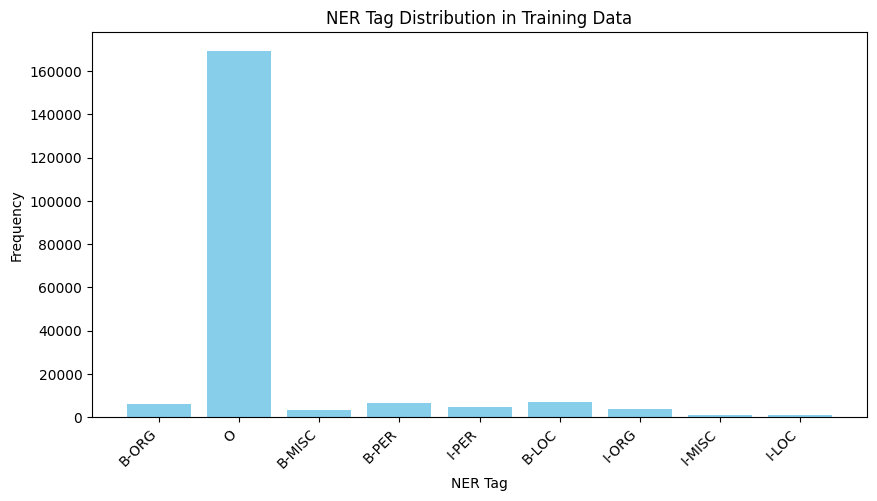

NER Tag Counts:
B-ORG: 6321
O: 169578
B-MISC: 3438
B-PER: 6600
I-PER: 4528
B-LOC: 7140
I-ORG: 3704
I-MISC: 1155
I-LOC: 1157


In [14]:
import matplotlib.pyplot as plt
from collections import Counter

all_ner_tags = [tag for tags in train_df['ner_labels'] for tag in tags]

# Count the occurrence of each NER tag
tag_counts = Counter(all_ner_tags)

# Plot the NER tag distribution
plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("NER Tag Distribution in Training Data")
plt.xlabel("NER Tag")
plt.ylabel("Frequency")
plt.show()

# Also display the counts
print("NER Tag Counts:")
for tag, count in tag_counts.items():
    print(f"{tag}: {count}")


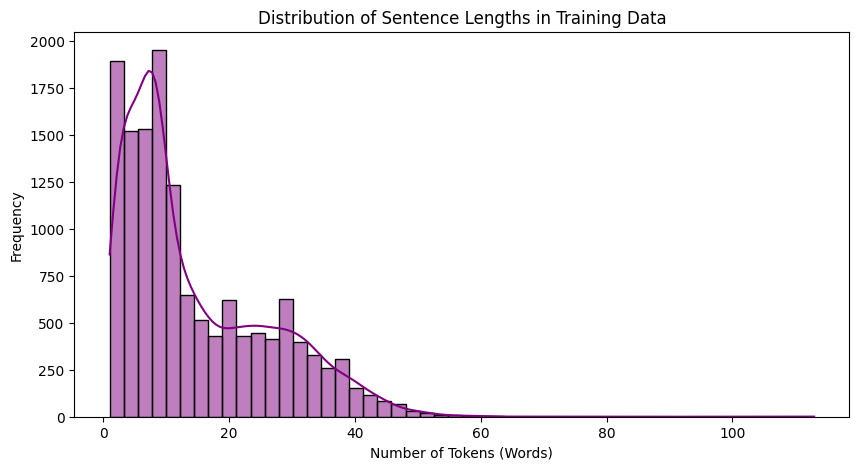

Sentence Length Statistics:
count    14041.000000
mean        14.501887
std         11.602756
min          1.000000
25%          6.000000
50%         10.000000
75%         22.000000
max        113.000000
Name: tokens, dtype: float64


In [15]:
import seaborn as sns

# Calculate the sentence length (number of tokens) for each sample 
train_df_sentence_length = train_df['tokens'].apply(len)

# Plot the distribution of sentence lengths
plt.figure(figsize=(10, 5))
sns.histplot(train_df_sentence_length, bins=50, kde=True, color='purple')
plt.title("Distribution of Sentence Lengths in Training Data")
plt.xlabel("Number of Tokens (Words)")
plt.ylabel("Frequency")
plt.show()

# Print basic statistics about sentence length
print("Sentence Length Statistics:")
print(train_df_sentence_length.describe())


In [16]:
train_df.shape

(14041, 3)

# NEVER Apply Traditional NLP Preprocessing For NER (With BERT) 🚨
👉 DO NOT: ❌ Remove Stopwords
👉 DO NOT: ❌ Lemmatize
👉 DO NOT: ❌ Remove Punctuation
👉 DO NOT: ❌ Lowercase Text

Why? 🤔

Because if you do any of these traditional NLP preprocessing steps:

🚨 You will destroy entity-level information (like Person, Organization, Location)
🚨 You will drastically reduce your F1-score (by at least 20-30%)
🚨 BERT already knows how to handle such text, and messing with it will make BERT useless. 


In [ ]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
model = BertForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(tag_list))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ✅ Function 1: Tokenize and Align Labels
def tokenize_and_align_labels(example):
    """
    Tokenizes input text and aligns NER labels with tokens (including subwords).
    Handles subword tokenization misalignment by adding -100 for ignored tokens.
    """
    # Tokenize
    tokenized_inputs = tokenizer(example['tokens'],
                                 truncation=True,
                                 is_split_into_words=True,
                                 padding='max_length',
                                 max_length=128,
                                 return_tensors='pt')

    # Align labels
    labels = []
    word_ids = tokenized_inputs.word_ids(batch_index=0)  # Only one sentence at a time
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example['ner_tags'][word_idx])
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    # Add labels to tokenized output
    tokenized_inputs['labels'] = torch.tensor(labels)
    return tokenized_inputs

In [19]:
def prepare_dataset(df):
    """
    Iterates through the DataFrame and calls tokenize_and_align_labels.
    Returns a HuggingFace Dataset with input_ids, attention_mask, and labels.
    """
    tokenized_data = []
    
    for i in range(len(df)):
        tokens = df.iloc[i]['tokens']
        labels = df.iloc[i]['ner_tags']

        # Call the tokenizer function
        tokenized_output = tokenize_and_align_labels({'tokens': tokens, 'ner_tags': labels})
        tokenized_data.append(tokenized_output)
    
    # Extract input_ids, attention_mask, and labels
    input_ids = [x['input_ids'].squeeze(0).tolist() for x in tokenized_data]
    attention_mask = [x['attention_mask'].squeeze(0).tolist() for x in tokenized_data]
    labels = [x['labels'].squeeze(0).tolist() for x in tokenized_data]
    
    # Convert to HuggingFace Dataset
    dataset = Dataset.from_dict({
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    })
    
    return dataset


In [20]:
# input_ids = [x['input_ids'] for x in tokenized_data]
# attention_mask = [x['attention_mask'] for x in tokenized_data]
# labels = [x['labels'] for x in tokenized_data]


In [21]:
train_dataset = prepare_dataset(train_df)
valid_dataset = prepare_dataset(valid_df)
test_dataset = prepare_dataset(test_df)

In [22]:
train_dataset[0]['input_ids']


[101,
 7327,
 19164,
 2446,
 2655,
 2000,
 17757,
 2329,
 12559,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [23]:
train_dataset[0]['labels']

[-100,
 3,
 0,
 7,
 0,
 0,
 0,
 7,
 0,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100]

In [24]:
# Define Evaluation Metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Convert predictions and labels to entity-level tags
    true_labels = [
        [tag_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    pred_labels = [
        [tag_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    '''
    pred_labels = []
    for prediction, label in zip(predictions, labels):
        current_sentence_predictions = []
        for p, l in zip(prediction, label):
            if l != -100:
                current_sentence_predictions.append(tag_list[p])
        
        pred_labels.append(current_sentence_predictions)
     '''
    # Use seqeval to evaluate at entity-level
    report = classification_report(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)

    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'classification_report': report
    }


In [25]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',   # ✅ Evaluate after every epoch
    save_strategy='epoch',         # ✅ Save after every epoch (VERY IMPORTANT)
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,   # ✅ Load the best model based on F1-score
    metric_for_best_model="f1"
)



c:\Users\thanredd\Desktop\Personal\DeccanAI\myenv\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)


In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Classification Report
1,0.084200,0.047986,0.936156,0.930472,0.941909,precision recall f1-score support LOC 0.94 0.97 0.95 1837 MISC 0.88 0.85 0.86 922 ORG 0.88 0.93 0.90 1341 PER 0.99 0.97 0.98 1839 micro avg 0.93 0.94 0.94 5939 macro avg 0.92 0.93 0.93 5939 weighted avg 0.93 0.94 0.94 5939
2,0.017600,0.047889,0.940037,0.932560,0.947634,precision recall f1-score support LOC 0.96 0.96 0.96 1837 MISC 0.84 0.88 0.86 922 ORG 0.91 0.91 0.91 1341 PER 0.97 0.99 0.98 1839 micro avg 0.93 0.95 0.94 5939 macro avg 0.92 0.94 0.93 5939 weighted avg 0.93 0.95 0.94 5939
3,0.009200,0.049611,0.945317,0.943178,0.947466,precision recall f1-score support LOC 0.97 0.96 0.96 1837 MISC 0.87 0.89 0.88 922 ORG 0.91 0.92 0.91 1341 PER 0.98 0.98 0.98 1839 micro avg 0.94 0.95 0.95 5939 macro avg 0.93 0.94 0.94 5939 weighted avg 0.94 0.95 0.95 5939
4,0.004100,0.054188,0.946918,0.943201,0.950665,precision recall f1-score support LOC 0.96 0.97 0.96 1837 MISC 0.88 0.89 0.88 922 ORG 0.91 0.92 0.92 1341 PER 0.98 0.98 0.98 1839 micro avg 0.94 0.95 0.95 5939 macro avg 0.93 0.94 0.94 5939 weighted avg 0.94 0.95 0.95 5939
5,0.011900,0.055109,0.946997,0.944854,0.949150,precision recall f1-score support LOC 0.96 0.97 0.96 1837 MISC 0.89 0.89 0.89 922 ORG 0.92 0.92 0.92 1341 PER 0.98 0.98 0.98 1839 micro avg 0.94 0.95 0.95 5939 macro avg 0.94 0.94 0.94 5939 weighted avg 0.94 0.95 0.95 5939


TrainOutput(global_step=4390, training_loss=0.030391268483585844, metrics={'train_runtime': 2321.8566, 'train_samples_per_second': 30.237, 'train_steps_per_second': 1.891, 'total_flos': 4586374939242240.0, 'train_loss': 0.030391268483585844, 'epoch': 5.0})

In [35]:
traine_results = trainer.evaluate()
print("Evaluation Results of trainer:")
print("======================================")
print(f"Loss: {traine_results['eval_loss']:.4f}")
print(f"Precision: {traine_results['eval_precision']:.4f}")
print(f" Recall: {traine_results['eval_recall']:.4f}")
print(f" F1-Score: {traine_results['eval_f1']:.4f}")
print("\nFULL DETAILED TESTING CLASSIFICATION REPORT:")
print(f"""{traine_results['eval_classification_report']}""")

Evaluation Results of trainer:
Loss: 0.0551
Precision: 0.9449
 Recall: 0.9491
 F1-Score: 0.9470

FULL DETAILED TESTING CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         LOC       0.96      0.97      0.96      1837
        MISC       0.89      0.89      0.89       922
         ORG       0.92      0.92      0.92      1341
         PER       0.98      0.98      0.98      1839

   micro avg       0.94      0.95      0.95      5939
   macro avg       0.94      0.94      0.94      5939
weighted avg       0.94      0.95      0.95      5939



In [37]:
# Evaluating the test dataset
test_results = trainer.evaluate(test_dataset)

print(" Evaluation Results on Test Dataset:")
print("======================================")
print(f"Loss: {test_results['eval_loss']:.4f}")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f" Recall: {test_results['eval_recall']:.4f}")
print(f" F1-Score: {test_results['eval_f1']:.4f}")
print("\nFULL DETAILED TESTING CLASSIFICATION REPORT:")
print(f"""{test_results['eval_classification_report']}""")

 Evaluation Results on Test Dataset:
Loss: 0.1542
Precision: 0.8989
 Recall: 0.9088
 F1-Score: 0.9038

FULL DETAILED TESTING CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         LOC       0.92      0.93      0.92      1667
        MISC       0.76      0.81      0.79       702
         ORG       0.87      0.87      0.87      1661
         PER       0.97      0.97      0.97      1616

   micro avg       0.90      0.91      0.90      5646
   macro avg       0.88      0.90      0.89      5646
weighted avg       0.90      0.91      0.90      5646



In [39]:
trainer.save_model("./best_bert_ner_model")

In [41]:
import pickle

# Save the trained model
with open('../saved_pkl/ner_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the tokenizer
with open('../saved_pkl/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

print("Model and Tokenizer Saved Successfully")


Model and Tokenizer Saved Successfully
